In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210512'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01,  8.61it/s]


(632049, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(629516, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [13]:
target_gu = '관악구'
target_dong = '남현동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 18 # in months

In [14]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(38, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
62447,서울특별시 관악구 남현동 1072-12,남부순환로256라길 30,하이원캐슬,40.13,22.65,25000,6,2016.0,4.0,2020-06-22,622.975330,5.0,대,543.4,제2종일반주거지역,지정되지않음,연립,완경사,정방형,세로각지(가),관악구,남현동
62448,서울특별시 관악구 남현동 1072-12,남부순환로256라길 30,하이원캐슬,40.13,22.65,26000,6,2016.0,4.0,2020-11-11,647.894343,5.0,대,543.4,제2종일반주거지역,지정되지않음,연립,완경사,정방형,세로각지(가),관악구,남현동
407253,서울특별시 관악구 남현동 1055-14,남부순환로262길 10-12,도담파크빌,29.67,20.19,34000,4,2020.0,0.0,2020-02-24,1145.938659,1.0,대,153.3,제3종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),관악구,남현동
407254,서울특별시 관악구 남현동 1055-14,남부순환로262길 10-12,도담파크빌,29.73,20.23,34000,2,2020.0,0.0,2020-02-24,1143.625967,1.0,대,153.3,제3종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),관악구,남현동
407255,서울특별시 관악구 남현동 1055-14,남부순환로262길 10-12,도담파크빌,29.67,20.19,34000,3,2020.0,0.0,2020-02-26,1145.938659,1.0,대,153.3,제3종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),관악구,남현동


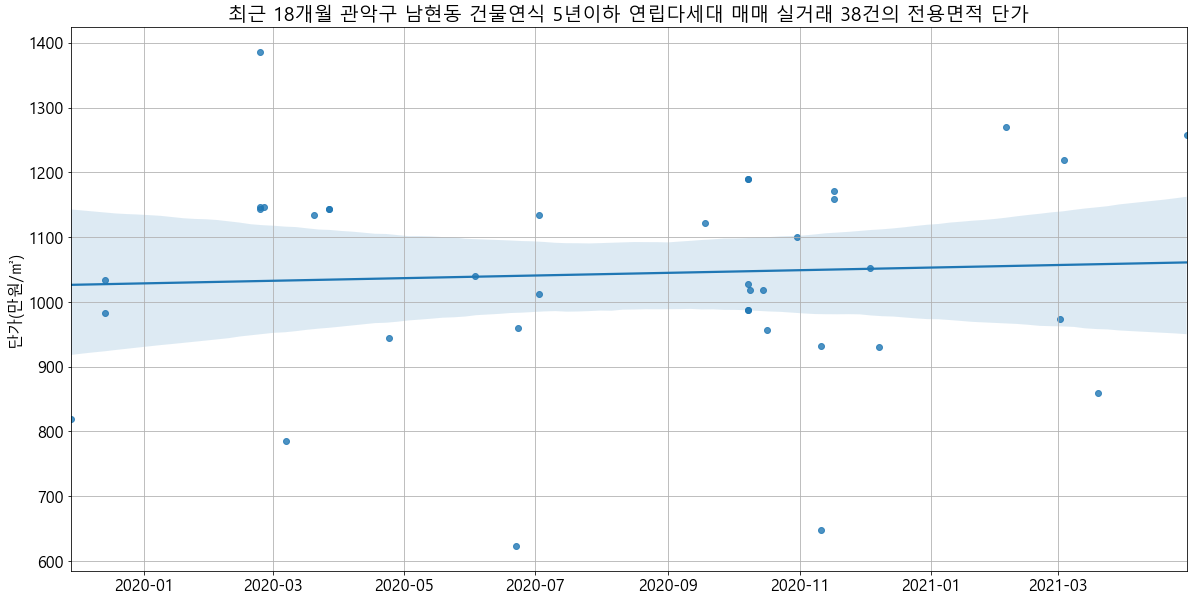

In [15]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [72]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(713, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
62425,서울특별시 관악구 남현동 1053-29,남현12길 37,더시크릿남현,55.74,31.70,46800,4,2018.0,1.0,2019-03-09,839.612487,3.0,대,333.9,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동
62426,서울특별시 관악구 남현동 1053-29,남현12길 37,더시크릿남현,50.62,41.15,56000,5,2018.0,1.0,2019-04-08,1106.282102,3.0,대,333.9,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동
62436,서울특별시 관악구 남현동 1072-12,남부순환로256라길 30,하이원캐슬,67.30,37.96,37200,3,2016.0,0.0,2016-05-12,552.748886,5.0,대,543.4,제2종일반주거지역,지정되지않음,연립,완경사,정방형,세로각지(가),관악구,남현동
62437,서울특별시 관악구 남현동 1072-12,남부순환로256라길 30,하이원캐슬,67.30,37.96,35500,3,2016.0,0.0,2016-05-16,527.488856,5.0,대,543.4,제2종일반주거지역,지정되지않음,연립,완경사,정방형,세로각지(가),관악구,남현동
62438,서울특별시 관악구 남현동 1072-12,남부순환로256라길 30,하이원캐슬,67.30,37.96,39500,4,2016.0,0.0,2016-06-28,586.924220,5.0,대,543.4,제2종일반주거지역,지정되지않음,연립,완경사,정방형,세로각지(가),관악구,남현동


In [73]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]
filenames

['지역별_연립다세대_실거래가격지수_200601_202102.xlsx']

In [74]:
sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])
print(sales_idx_df.shape)
sales_idx_df.head()

(1, 365)


지 역 2006년 01월     2006년 02월       2006년 03월       2006년 04월  \
  Unnamed: 0_level_1        지수 변동률        지수   변동률        지수   변동률        지수   
0                 서울    50.174   -    49.868 -0.61    51.623  3.52    53.023   

        2006년 05월       2006년 06월       2006년 07월       2006년 08월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.71    53.471  0.84    53.541  0.13    55.004  2.73    57.288  4.15   

  2006년 09월       2006년 10월       2006년 11월       2006년 12월      2007년 01월  \
         지수   변동률        지수   변동률        지수   변동률        지수  변동률        지수   
0    59.279  3.48    62.222  4.96    64.449  3.58    65.672  1.9    67.433   

        2007년 02월       2007년 03월       2007년 04월       2007년 05월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.68    67.316 -0.17    68.825  2.24    70.773  2.83    71.227  0.64   

  2007년 06월       2007년 07월       2007년 08월       2007년 09월       2007년 10월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    73.664  3.42    75.501  2.49    76.363  1.14    77.716  1.77    80.412   

        2007년 11월       2007년 12월       2008년 01월       2008년 02월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  3.47    81.322  1.13    82.895  1.93    85.315  2.92    86.909  1.87   

  2008년 03월       2008년 04월       2008년 05월       2008년 06월      2008년 07월  \
         지수   변동률        지수   변동률        지수   변동률        지수  변동률        지수   
0    91.072  4.79    94.429  3.69    97.021  2.74    97.898  0.9    96.642   

        2008년 08월       2008년 09월       2008년 10월       2008년 11월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -1.28    95.315 -1.37    94.819 -0.52    91.804 -3.18    87.269 -4.94   

  2008년 12월       2009년 01월       2009년 02월       2009년 03월       2009년 04월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    84.235 -3.48    84.433  0.23    85.689  1.49    86.418  0.85    88.165   

        2009년 05월       2009년 06월       2009년 07월       2009년 08월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.02    90.322  2.45    90.921  0.66    92.781  2.05    94.755  2.13   

  2009년 09월       2009년 10월       2009년 11월       2009년 12월       2010년 01월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    96.235  1.56    95.553 -0.71    94.461 -1.14    94.582  0.13    96.148   

        2010년 02월       2010년 03월       2010년 04월       2010년 05월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  1.66     95.87 -0.29    95.305 -0.59    94.813 -0.52    94.425 -0.41   

  2010년 06월       2010년 07월       2010년 08월       2010년 09월       2010년 10월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    92.574 -1.96    91.908 -0.72    91.419 -0.53    91.379 -0.04    90.753   

        2010년 11월       2010년 12월       2011년 01월       2011년 02월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -0.69    91.374  0.68    91.589  0.24     91.95  0.39    92.705  0.82   

  2011년 03월       2011년 04월       2011년 05월       2011년 06월       2011년 07월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    92.885  0.19     92.35 -0.58    92.618  0.29    91.888 -0.79    91.628   

        2011년 08월       2011년 09월       2011년 10월       2011년 11월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -0.28    91.073 -0.61    91.898  0.91    91.392 -0.55    90.653 -0.81   

  2011년 12월       2012년 01월       2012년 02월       2012년 03월       2012년 04월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    89.877 -0.86    90.529  0.73    90.105 -0.47    89.855 -0.28    88.579   

        2012년 05월       2012년 06월       2012년 07월       2012년 08월     

In [75]:
sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

In [76]:
sales_idx_df.columns = sales_idx_cols_list
sales_idx_df.head()

,지 역,2006년 01월_지수,2006년 01월_변동률,2006년 02월_지수,2006년 02월_변동률,2006년 03월_지수,2006년 03월_변동률,2006년 04월_지수,2006년 04월_변동률,2006년 05월_지수,2006년 05월_변동률,2006년 06월_지수,2006년 06월_변동률,2006년 07월_지수,2006년 07월_변동률,2006년 08월_지수,2006년 08월_변동률,2006년 09월_지수,2006년 09월_변동률,2006년 10월_지수,2006년 10월_변동률,2006년 11월_지수,2006년 11월_변동률,2006년 12월_지수,2006년 12월_변동률,2007년 01월_지수,2007년 01월_변동률,2007년 02월_지수,2007년 02월_변동률,2007년 03월_지수,2007년 03월_변동률,2007년 04월_지수,2007년 04월_변동률,2007년 05월_지수,2007년 05월_변동률,2007년 06월_지수,2007년 06월_변동률,2007년 07월_지수,2007년 07월_변동률,2007년 08월_지수,2007년 08월_변동률,2007년 09월_지수,2007년 09월_변동률,2007년 10월_지수,2007년 10월_변동률,2007년 11월_지수,2007년 11월_변동률,2007년 12월_지수,2007년 12월_변동률,2008년 01월_지수,2008년 01월_변동률,2008년 02월_지수,2008년 02월_변동률,2008년 03월_지수,2008년 03월_변동률,2008년 04월_지수,2008년 04월_변동률,2008년 05월_지수,2008년 05월_변동률,2008년 06월_지수,2008년 06월_변동률,2008년 07월_지수,2008년 07월_변동률,2008년 08월_지수,2008년 08월_변동률,2008년 09월_지수,2008년 09월_변동률,2008년 10월_지수,2008년 10월_변동률,2008년 11월_지수,2008년 11월_변동률,2008년 12월_지수,2008년 12월_변동률,2009년 01월_지수,2009년 01월_변동률,2009년 02월_지수,2009년 02월_변동률,2009년 03월_지수,2009년 03월_변동률,2009년 04월_지수,2009년 04월_변동률,2009년 05월_지수,2009년 05월_변동률,2009년 06월_지수,2009년 06월_변동률,2009년 07월_지수,2009년 07월_변동률,2009년 08월_지수,2009년 08월_변동률,2009년 09월_지수,2009년 09월_변동률,2009년 10월_지수,2009년 10월_변동률,2009년 11월_지수,2009년 11월_변동률,2009년 12월_지수,2009년 12월_변동률,2010년 01월_지수,2010년 01월_변동률,2010년 02월_지수,2010년 02월_변동률,2010년 03월_지수,2010년 03월_변동률,2010년 04월_지수,2010년 04월_변동률,2010년 05월_지수,2010년 05월_변동률,2010년 06월_지수,2010년 06월_변동률,2010년 07월_지수,2010년 07월_변동률,2010년 08월_지수,2010년 08월_변동률,2010년 09월_지수,2010년 09월_변동률,2010년 10월_지수,2010년 10월_변동률,2010년 11월_지수,2010년 11월_변동률,2010년 12월_지수,2010년 12월_변동률,2011년 01월_지수,2011년 01월_변동률,2011년 02월_지수,2011년 02월_변동률,2011년 03월_지수,2011년 03월_변동률,2011년 04월_지수,2011년 04월_변동률,2011년 05월_지수,2011년 05월_변동률,2011년 06월_지수,2011년 06월_변동률,2011년 07월_지수,2011년 07월_변동률,2011년 08월_지수,2011년 08월_변동률,2011년 09월_지수,2011년 09월_변동률,2011년 10월_지수,2011년 10월_변동률,2011년 11월_지수,2011년 11월_변동률,2011년 12월_지수,2011년 12월_변동률,2012년 01월_지수,2012년 01월_변동률,2012년 02월_지수,2012년 02월_변동률,2012년 03월_지수,2012년 03월_변동률,2012년 04월_지수,2012년 04월_변동률,2012년 05월_지수,2012년 05월_변동률,2012년 06월_지수,2012년 06월_변동률,2012년 07월_지수,2012년 07월_변동률,2012년 08월_지수,2012년 08월_변동률,2012년 09월_지수,2012년 09월_변동률,2012년 10월_지수,2012년 10월_변동률,2012년 11월_지수,2012년 11월_변동률,2012년 12월_지수,2012년 12월_변동률,2013년 01월_지수,2013년 01월_변동률,2013년 02월_지수,2013년 02월_변동률,2013년 03월_지수,2013년 03월_변동률,2013년 04월_지수,2013년 04월_변동률,2013년 05월_지수,2013년 05월_변동률,2013년 06월_지수,2013년 06월_변동률,2013년 07월_지수,2013년 07월_변동률,2013년 08월_지수,2013년 08월_변동률,2013년 09월_지수,2013년 09월_변동률,2013년 10월_지수,2013년 10월_변동률,2013년 11월_지수,2013년 11월_변동률,2013년 12월_지수,2013년 12월_변동률,2014년 01월_지수,2014년 01월_변동률,2014년 02월_지수,2014년 02월_변동률,2014년 03월_지수,2014년 03월_변동률,2014년 04월_지수,2014년 04월_변동률,2014년 05월_지수,2014년 05월_변동률,2014년 06월_지수,2014년 06월_변동률,2014년 07월_지수,2014년 07월_변동률,2014년 08월_지수,2014년 08월_변동률,2014년 09월_지수,2014년 09월_변동률,2014년 10월_지수,2014년 10월_변동률,2014년 11월_지수,2014년 11월_변동률,2014년 12월_지수,2014년 12월_변동률,2015년 01월_지수,2015년 01월_변동률,2015년 02월_지수,2015년 02월_변동률,2015년 03월_지수,2015년 03월_변동률,2015년 04월_지수,2015년 04월_변동률,2015년 05월_지수,2015년 05월_변동률,2015년 06월_지수,2015년 06월_변동률,2015년 07월_지수,2015년 07월_변동률,2015년 08월_지수,2015년 08월_변동률,2015년 09월_지수,2015년 09월_변동률,2015년 10월_지수,2015년 10월_변동률,2015년 11월_지수,2015년 11월_변동률,2015년 12월_지수,2015년 12월_변동률,2016년 01월_지수,2016년 01월_변동률,2016년 02월_지수,2016년 02월_변동률,2016년 03월_지수,2016년 03월_변동률,2016년 04월_지수,2016년 04월_변동률,2016년 05월_지수,2016년 05월_변동률,2016년 06월_지수,2016년 06월_변동률,2016년 07월_지수,2016년 07월_변동률,2016년 08월_지수,2016년 08월_변동률,2016년 09월_지수,2016년 09월_변동률,2016년 10월_지수,2016년 10월_변동률,2016년 11월_지수,2016년 11월_변동률,2016년 12월_지수,2016년 12월_변동률,2017년 01월_지수,2017년 01월_변동률,2017년 02월_지수,2017년 02월_변동률,2017년 03월_지수,2017년 03월_변동률,2017년 04월_지수,2017년 04월_변동률,2017년 05월_지수,2017년 05월_변동률,2017년 06월_지수,2017년 06월_변동률,2017년 07월_지수,2017년 07월_변동률,2017년 08월_지수,2017년 08월_변동률,2017년 09월_지수,2017년 09월_변동률,2017년 10월_지수,2017년 10월_변동률,2017년 11월_지수,2017년 11월_변동률,2017년 12월_지수,2017년 12월_변동률,2018년 01월_지수,2018년 01월_변동률,2018년 02월_지수,2018년 02월_변동률,2018년 03월_지수,2018년 03월_변동률,2018년 04월_지수,2018년 04월_변동률

In [77]:
last_idx = sales_idx_df.iloc[0,-2]
last_idx

124.636

In [78]:
last_date = sales_idx_df.columns[-1].split('_')[0]
last_date

'2021년 02월'

In [79]:
last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
last_date

'2021-02-01'

In [80]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [81]:
target_upper_limit_df = target_df2[target_df2['계약날짜'] <= pd.to_datetime(last_date)]

In [82]:
target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)

In [83]:
target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx

In [84]:
target_upper_limit_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,계약날짜_실거래지수,지수적용단가
62425,서울특별시 관악구 남현동 1053-29,남현12길 37,더시크릿남현,55.74,31.70,46800,4,2018.0,1.0,2019-03-09,839.612487,3.0,대,333.9,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,105.228,994.468600
62426,서울특별시 관악구 남현동 1053-29,남현12길 37,더시크릿남현,50.62,41.15,56000,5,2018.0,1.0,2019-04-08,1106.282102,3.0,대,333.9,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,105.608,1305.607303
62436,서울특별시 관악구 남현동 1072-12,남부순환로256라길 30,하이원캐슬,67.30,37.96,37200,3,2016.0,0.0,2016-05-12,552.748886,5.0,대,543.4,제2종일반주거지역,지정되지않음,연립,완경사,정방형,세로각지(가),관악구,남현동,92.646,743.609115
62437,서울특별시 관악구 남현동 1072-12,남부순환로256라길 30,하이원캐슬,67.30,37.96,35500,3,2016.0,0.0,2016-05-16,527.488856,5.0,대,543.4,제2종일반주거지역,지정되지않음,연립,완경사,정방형,세로각지(가),관악구,남현동,92.646,709.626978
62438,서울특별시 관악구 남현동 1072-12,남부순환로256라길 30,하이원캐슬,67.30,37.96,39500,4,2016.0,0.0,2016-06-28,586.924220,5.0,대,543.4,제2종일반주거지역,지정되지않음,연립,완경사,정방형,세로각지(가),관악구,남현동,92.862,787.748348


In [85]:
target_df2['지수적용단가'] = target_df2['단가(만원/㎡)']

In [86]:
target_df2.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']

In [87]:
target_df2['평가날짜'] = target_df2['계약날짜']

In [88]:
target_df2.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '15')

<AxesSubplot:title={'center':'관악구 남현동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 713건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

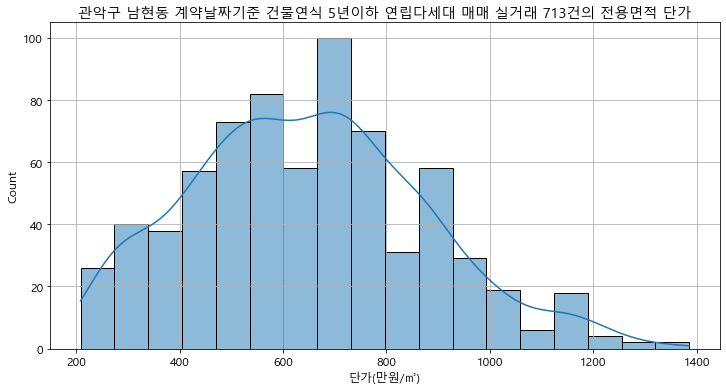

In [89]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [90]:
concat_df = pd.concat([target_df2])

In [91]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [92]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [93]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(321, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 관악구 남현동 1053-11,남부순환로260길 52,삼성쉐르빌나동,81.32,46.39,23000,5,2002.0,5.0,2007-05-21,282.833251,19.0,대,343.6,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),관악구,남현동,494.913518,2021-02-15,282.833251,494.913518
1,서울특별시 관악구 남현동 1053-13,남부순환로260길 60,프라임센트레빌(1053-13),59.13,34.58,28800,1,2011.0,4.0,2015-03-20,487.062405,10.0,대,367.6,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,691.107606,2021-02-15,481.322230,674.473647
2,서울특별시 관악구 남현동 1053-13,남부순환로260길 60,프라임센트레빌(1053-13),70.44,34.58,33500,3,2011.0,1.0,2012-02-05,475.582056,10.0,대,367.6,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,657.839688,2021-02-15,481.322230,674.473647
3,서울특별시 관악구 남현동 1053-2,남부순환로256길 6,예주아트빌,52.32,31.57,40500,1,2015.0,5.0,2020-07-16,774.082569,6.0,대,344.3,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,825.661575,2021-02-15,645.636366,812.786909
4,서울특별시 관악구 남현동 1053-2,남부순환로256길 6,예주아트빌,59.27,35.76,34000,4,2015.0,0.0,2015-12-01,573.646027,6.0,대,344.3,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,795.577360,2021-02-15,645.636366,812.786909


In [94]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(108, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 관악구 남현동 1053-11,남부순환로260길 52,삼성쉐르빌나동,81.32,46.39,23000,5,2002.0,5.0,2007-05-21,282.833251,19.0,대,343.6,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),관악구,남현동,494.913518,2021-02-15,282.833251,494.913518
2,서울특별시 관악구 남현동 1053-13,남부순환로260길 60,프라임센트레빌(1053-13),70.44,34.58,33500,3,2011.0,1.0,2012-02-05,475.582056,10.0,대,367.6,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,657.839688,2021-02-15,481.322230,674.473647
5,서울특별시 관악구 남현동 1053-2,남부순환로256길 6,예주아트빌,74.68,45.06,44000,3,2015.0,0.0,2015-12-26,589.180503,6.0,대,344.3,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,817.121792,2021-02-15,645.636366,812.786909
9,서울특별시 관악구 남현동 1053-20,남부순환로260길 86,라비앙로즈,74.94,44.70,37500,2,2012.0,2.0,2014-03-04,500.400320,9.0,대,385.1,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,726.390570,2021-02-15,554.214332,783.438985
10,서울특별시 관악구 남현동 1053-26,남현12길 38,우형빌리지,21.08,13.32,18000,4,2014.0,3.0,2017-08-30,853.889943,7.0,대,429.2,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),관악구,남현동,1074.559293,2021-02-15,853.889943,1074.559293
14,서울특별시 관악구 남현동 1053-27,남현12길 40,미연제,56.44,35.92,33500,4,2014.0,1.0,2015-02-15,593.550673,7.0,대,350.5,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),관악구,남현동,849.713787,2021-02-15,682.025733,959.975054
16,서울특별시 관악구 남현동 1053-29,남현12길 37,더시크릿남현,55.74,31.70,46800,4,2018.0,1.0,2019-03-09,839.612487,3.0,대,333.9,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),관악구,남현동,994.468600,2021-02-15,972.947294,1150.037952
20,서울특별시 관악구 남현동 1053-8,남부순환로260길 42,팰리스타운,50.82,29.84,37000,3,2015.0,3.0,2018-09-27,728.059819,6.0,대,405.3,제2종일반주거지역,지정되지않음,단독,완경사,사다리형,소로한면,관악구,남현동,852.650376,2021-02-15,847.207196,972.870603
23,서울특별시 관악구 남현동 1054-20,남부순환로260길 22,예지현,84.86,57.90,34000,2,2010.0,3.0,2013-11-27,400.659910,11.0,대,405.2,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,소로각지,관악구,남현동,585.073972,2021-02-15,402.820679,562.624752
24,서울특별시 관악구 남현동 1054-23,남부순환로256가길 16,초원빌라,76.62,44.48,18000,3,2001.0,5.0,2006-05-17,234.925607,20.0,대,355.8,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),관악구,남현동,547.590057,2021-02-15,234.925607,547.590057


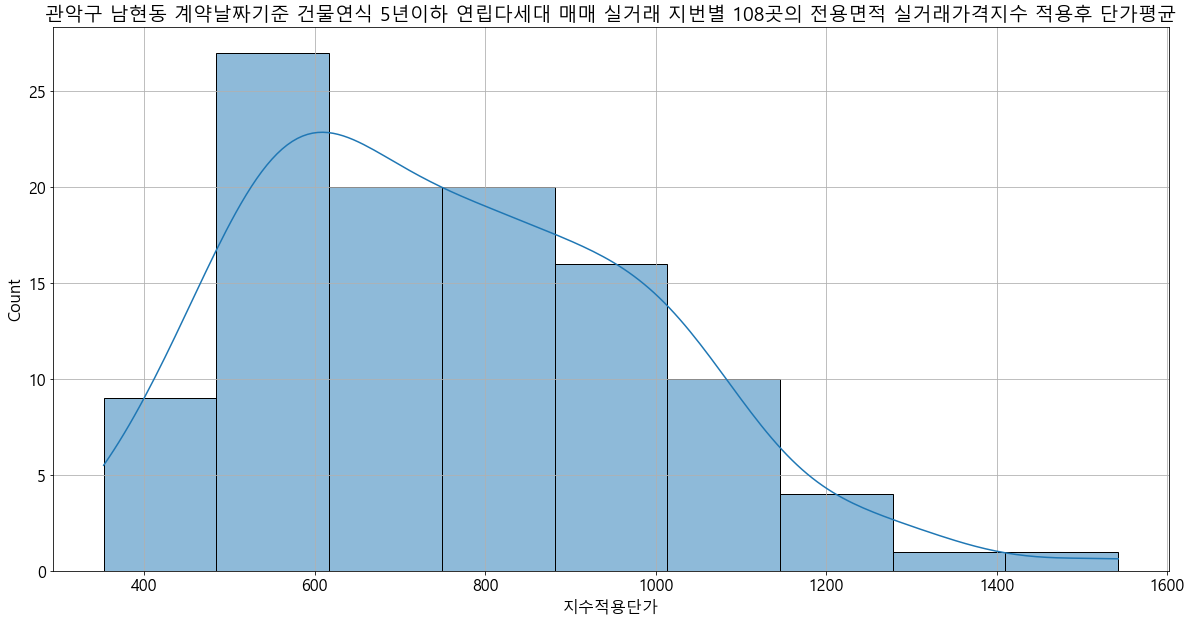

In [95]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [96]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [97]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가평균', '평가날짜', '지수적용단가평균', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건축년도,계약날짜,단가평균,평가날짜,지수적용단가평균,용도지역명1
0,서울특별시 관악구 남현동 1053-11,삼성쉐르빌나동,2002.0,2007-05-21,282.833251,2021-02-15,494.913518,제2종일반주거지역
1,서울특별시 관악구 남현동 1053-13,프라임센트레빌(1053-13),2011.0,2012-02-05,481.322230,2021-02-15,674.473647,제2종일반주거지역
2,서울특별시 관악구 남현동 1053-2,예주아트빌,2015.0,2015-12-26,645.636366,2021-02-15,812.786909,제2종일반주거지역
3,서울특별시 관악구 남현동 1053-20,라비앙로즈,2012.0,2014-03-04,554.214332,2021-02-15,783.438985,제2종일반주거지역
4,서울특별시 관악구 남현동 1053-26,우형빌리지,2014.0,2017-08-30,853.889943,2021-02-15,1074.559293,제2종일반주거지역
5,서울특별시 관악구 남현동 1053-27,미연제,2014.0,2015-02-15,682.025733,2021-02-15,959.975054,제2종일반주거지역
6,서울특별시 관악구 남현동 1053-29,더시크릿남현,2018.0,2019-03-09,972.947294,2021-02-15,1150.037952,제2종일반주거지역
7,서울특별시 관악구 남현동 1053-8,팰리스타운,2015.0,2018-09-27,847.207196,2021-02-15,972.870603,제2종일반주거지역
8,서울특별시 관악구 남현동 1054-20,예지현,2010.0,2013-11-27,402.820679,2021-02-15,562.624752,제2종일반주거지역
9,서울특별시 관악구 남현동 1054-23,초원빌라,2001.0,2006-05-17,234.925607,2021-02-15,547.590057,제2종일반주거지역


In [98]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)